In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def pieOthers(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
        
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    colorsX = plt.cm.tab20.colors
    patches, texts = plt.pie(df2['value'], shadow=True, startangle=90, colors = colorsX)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [4]:
cols = ['charger','health','voltage','temperature','capacity','charge_counter','current_average','current_now','energy_counter']
df = prepare('2-datasets/battery_details.parquet',cols)

In [5]:
df.head(100)

,charger,health,voltage,temperature,capacity,charge_counter,current_average,current_now,energy_counter
0,UNPLUGGED,GOOD,4.05,28.500000,0,0,0,-229,-1
1,UNPLUGGED,GOOD,4.05,28.500000,0,0,0,-229,-1
2,UNPLUGGED,GOOD,4.04,29.000000,0,0,0,-248,-1
3,UNPLUGGED,GOOD,3.97,29.900000,0,0,0,-313,-1
4,UNPLUGGED,GOOD,4.03,29.200001,0,0,0,-234,-1
5,AC,GOOD,4.20,27.299999,0,0,0,518,-1
6,AC,GOOD,4.22,26.000000,0,0,0,538,-1
7,AC,GOOD,4.22,25.000000,0,0,0,480,-1
8,AC,GOOD,4.24,25.200001,0,0,0,528,-1
9,AC,GOOD,4.27,24.100000,0,0,0,555,-1


In [6]:
dfChargerGB = df.groupby(['charger'])['charger'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfHealthGB = df.groupby(['health'])['health'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

In [7]:
print("BatteryDetails:"+str(len(df.index)))

BatteryDetails:11957118


     charger    count
0         AC  5999594
1  UNPLUGGED  5493938
2        USB   463586


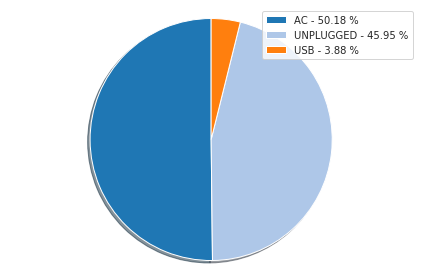

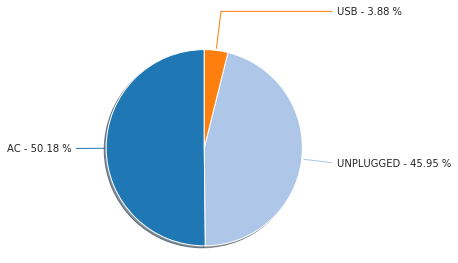

In [8]:
print(dfChargerGB)

pieOthers(dfChargerGB['charger'], dfChargerGB['count'],0)


                health     count
1                 GOOD  11907787
4              UNKNOWN     36166
2         OVER VOLTAGE      5301
0                 DEAD      4413
3             OVERHEAT      2604
5  UNSPECIFIED FAILURE       847


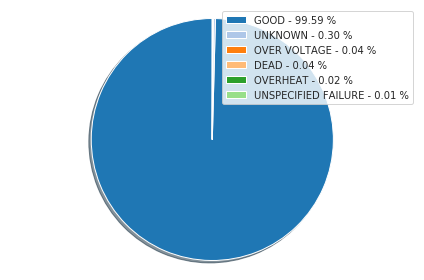

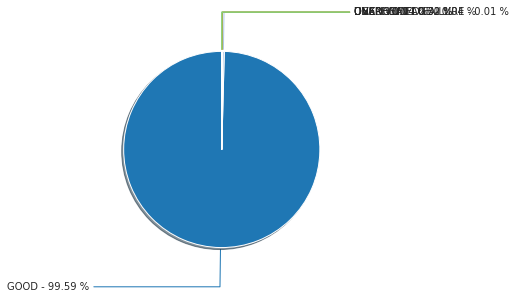

In [9]:
print(dfHealthGB)

pieOthers(dfHealthGB['health'], dfHealthGB['count'],0)


In [10]:
dfVoltageMean = df['voltage'].mean()
dfVoltageMin = df['voltage'].min()
dfVoltageMax = df['voltage'].max()

dfTemperatureMean = df['temperature'].mean()
dfTemperatureMin = df['temperature'].min()
dfTemperatureMax = df['temperature'].max()


In [11]:
print("Mean Voltage:"+str(dfVoltageMean))
print("Min Voltage:"+str(dfVoltageMin))
print("Max Voltage:"+str(dfVoltageMax))
print()
print("Mean Temperature:"+str(dfTemperatureMean))
print("Min Temperature:"+str(dfTemperatureMin))
print("Max Temperature:"+str(dfTemperatureMax))



Mean Voltage:23.156702
Min Voltage:0.0
Max Voltage:4415.1

Mean Temperature:30.301554
Min Temperature:-40.0
Max Temperature:120.0


In [12]:
#dfCapacityGB = df.groupby(['capacity'])['capacity'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
#dfEnergyCounterGB = df.groupby(['energy_counter'])['energy_counter'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
#print(dfCapacityGB)
#print(dfEnergyCounterGB)